<a href="https://colab.research.google.com/github/puckerm/test_project/blob/main/6%EC%A3%BC%EC%B0%A8_%EC%8B%A4%EC%8A%B5%EA%B3%BC%EC%A0%9C_LSTM%EC%9D%84_%ED%99%9C%EC%9A%A9%ED%95%9C_%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90_%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM을 활용한 주가 예측 모델

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- TensorFlow Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

## 필요한 모듈 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (15, 20)

plt.rcParams['font.family'] = 'NanumGothic'

## 데이터 (FinanceDataReader)

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**설치

In [2]:
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import FinanceDataReader as fdr

In [35]:

celltrion = fdr.DataReader('068270')

매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 받아옵니다.

기본 **오름차순 정렬**이 된 데이터임을 알 수 있습니다.

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

다음과 같이 `2017`을 같이 넘겨주면, 해당 시점 이후의 주식 데이터를 가져옵니다.

**시작**과 **끝** 날짜를 지정하여 범위 데이터를 가져올 수 있습니다.

In [37]:
ford = fdr.DataReader('F', '1992-01-01', '2019-12-30')

In [38]:
ford.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
1992-01-02,8.24,7.92,8.63,7.85,6640000.0,0.0352
1992-01-03,8.59,8.34,8.63,8.31,8680000.0,0.0425
1992-01-06,8.73,8.73,8.95,8.66,11470000.0,0.0163
1992-01-07,8.63,8.70,8.73,8.56,5840000.0,-0.0115
1992-01-08,8.59,8.49,8.63,8.38,5410000.0,-0.0046


In [39]:
ford.tail()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2019-12-23,9.44,9.50,9.57,9.40,54800000.0,-0.0042
2019-12-24,9.47,9.44,9.49,9.43,11880000.0,0.0032
2019-12-26,9.45,9.47,9.49,9.43,28980000.0,-0.0021
2019-12-27,9.36,9.45,9.46,9.35,28270000.0,-0.0095
2019-12-30,9.25,9.34,9.35,9.23,36090000.0,-0.0118


그 밖에 **금, 은과 같은 현물**, **달러와 같은 화폐** 데이터도 가져올 수 있습니다.

**삼성전자**의 주가데이터를 가져와서 예측

In [41]:
STOCK_CODE = '068270'

In [42]:
stock = fdr.DataReader(STOCK_CODE)

In [43]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2005-07-19,5597,6433,5437,6439,0,NaN
2005-07-20,6424,6424,5470,5475,0,-0.149713
2005-07-21,5391,5499,4785,4798,0,-0.123653
2005-07-22,4884,4884,4617,4664,0,-0.027928
2005-07-25,4587,4967,4587,4723,0,0.012650


In [44]:
stock.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-07-06,181500,190000,181500,186500,892324,0.019126
2022-07-07,188000,189000,184500,187500,369149,0.005362
2022-07-08,187000,187000,178500,182500,755595,-0.026667
2022-07-11,181500,187500,181500,186000,344098,0.019178
2022-07-12,187500,191500,185000,187500,420319,0.008065


In [45]:
stock.index

DatetimeIndex(['2005-07-19', '2005-07-20', '2005-07-21', '2005-07-22',
               '2005-07-25', '2005-07-26', '2005-07-27', '2005-07-28',
               '2005-07-29', '2005-08-01',
               ...
               '2022-06-29', '2022-06-30', '2022-07-01', '2022-07-04',
               '2022-07-05', '2022-07-06', '2022-07-07', '2022-07-08',
               '2022-07-11', '2022-07-12'],
              dtype='datetime64[ns]', name='Date', length=4200, freq=None)

위에서 보시는 바와 같이 index가 `DatetimeIndex`로 지정되어 있습니다.

`DatetimeIndex`로 정의되어 있다면, 아래와 같이 연도, 월, 일을 쪼갤 수 있으며, **월별, 연도별 피벗데이터**를 만들때 유용하게 활용할 수 있습니다.

In [46]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

In [33]:
stock.head()

""


## 시각화

Text(0, 0.5, 'price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


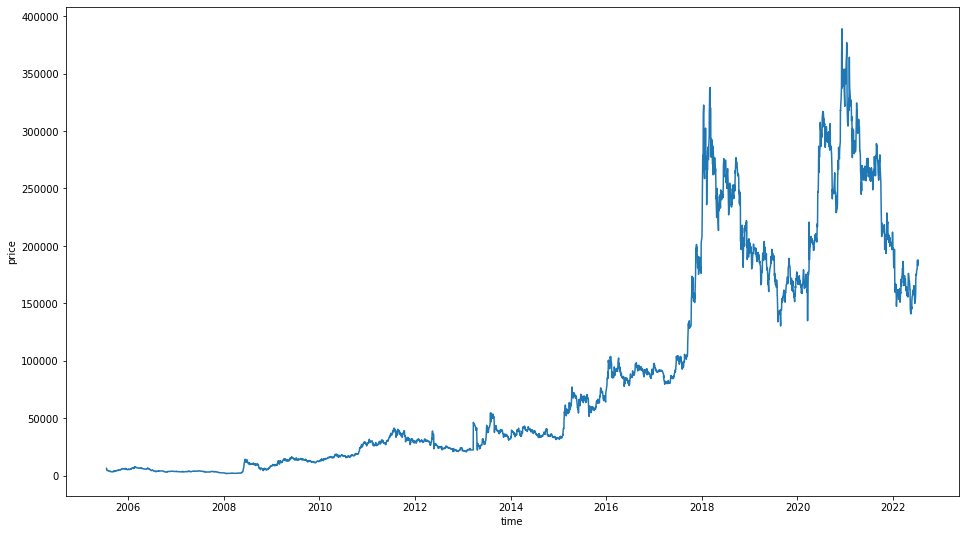

In [47]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

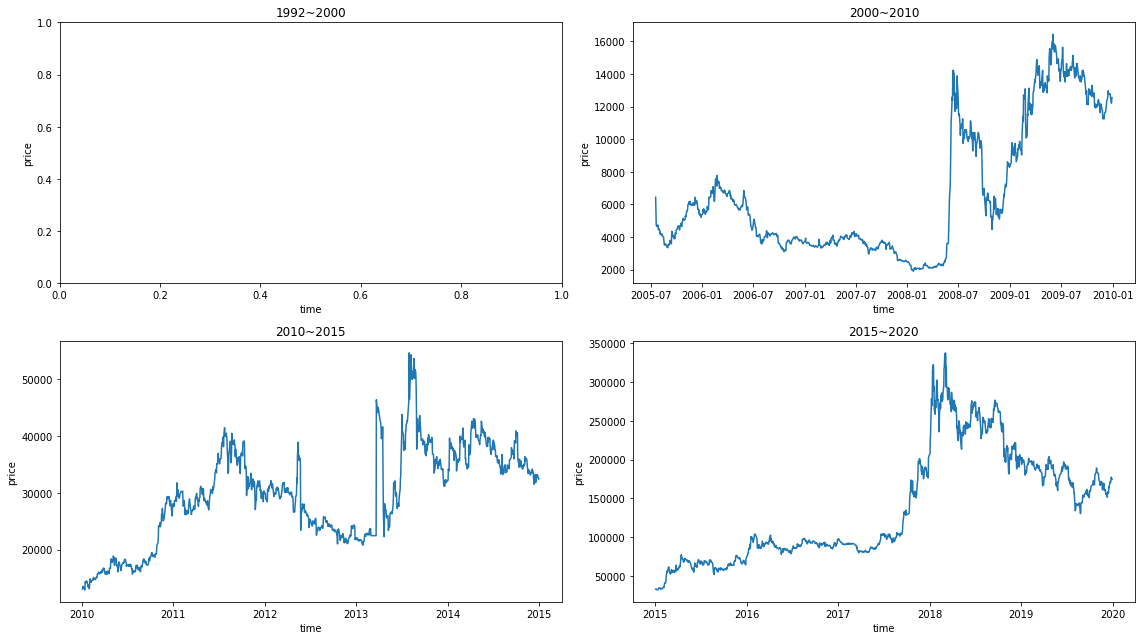

In [49]:
time_steps = [['1992', '2000'], # 특정기간을 설정하여 subplot 표현
              ['2000', '2010'], 
              ['2010', '2015'], 
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax) # 선형플롯
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

## 데이터 전처리

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [50]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # MinMaxScaler 인스턴스화

# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[0.01464589, 0.01654144, 0.01477225, 0.01173881, 0.        ],
       [0.01680993, 0.0165183 , 0.01486191, 0.00924789, 0.        ],
       [0.01410684, 0.01413981, 0.01300077, 0.00749857, 0.        ],
       ...,
       [0.48933025, 0.48084093, 0.48498186, 0.46666856, 0.0654205 ],
       [0.47493818, 0.4821266 , 0.49313282, 0.47571233, 0.0297925 ],
       [0.49063862, 0.49241197, 0.50264227, 0.47958822, 0.03639182]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [51]:
df = pd.DataFrame(scaled, columns=scale_cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    4200 non-null   float64
 1   High    4200 non-null   float64
 2   Low     4200 non-null   float64
 3   Close   4200 non-null   float64
 4   Volume  4200 non-null   float64
dtypes: float64(5)
memory usage: 164.2 KB


## train / test 분할

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [54]:
x_train.shape, y_train.shape

((3360, 4), (3360,))

In [55]:
x_test.shape, y_test.shape

((840, 4), (840,))

In [56]:
x_train

,Open,High,Low,Volume
0,0.014646,0.016541,0.014772,0.000000
1,0.016810,0.016518,0.014862,0.000000
2,0.014107,0.014140,0.013001,0.000000
3,0.012780,0.012558,0.012544,0.000000
4,0.012003,0.012772,0.012463,0.000000
...,...,...,...,...
3355,0.519122,0.511304,0.527758,0.042844
3356,0.514307,0.507753,0.527758,0.038571
3357,0.510691,0.504196,0.516502,0.063235
3358,0.503466,0.503016,0.521504,0.047142


## TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

In [57]:
import tensorflow as tf

In [58]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의합니다.

In [59]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [60]:
# train_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [61]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


## 모델

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [63]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [64]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [65]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    105/Unknown - 14s 7ms/step - loss: 2.4968e-04 - mse: 4.9935e-04
Epoch 1: val_loss improved from inf to 0.00098, saving model to tmp/ckeckpointer.ckpt
105/105 [==============================] - 15s 16ms/step - loss: 2.4968e-04 - mse: 4.9935e-04 - val_loss: 9.8136e-04 - val_mse: 0.0020
Epoch 2/50
 99/105 [===========================>..] - ETA: 0s - loss: 1.5546e-04 - mse: 3.1091e-04
Epoch 2: val_loss improved from 0.00098 to 0.00097, saving model to tmp/ckeckpointer.ckpt
105/105 [==============================] - 1s 9ms/step - loss: 1.6667e-04 - mse: 3.3333e-04 - val_loss: 9.6544e-04 - val_mse: 0.0019
Epoch 3/50
101/105 [===========================>..] - ETA: 0s - loss: 1.4107e-04 - mse: 2.8213e-04
Epoch 3: val_loss improved from 0.00097 to 0.00070, saving model to tmp/ckeckpointer.ckpt
105/105 [==============================] - 1s 9ms/step - loss: 1.4458e-04 - mse: 2.8917e-04 - val_loss: 6.9526e-04 - val_mse: 0.0014
Epoch 4/50
100/105 [===========================>..] - ET

저장한 ModelCheckpoint 를 로드합니다.

In [66]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.

In [67]:
pred = model.predict(test_data)

In [68]:
pred.shape

(820, 1)

## 예측 데이터 시각화

아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

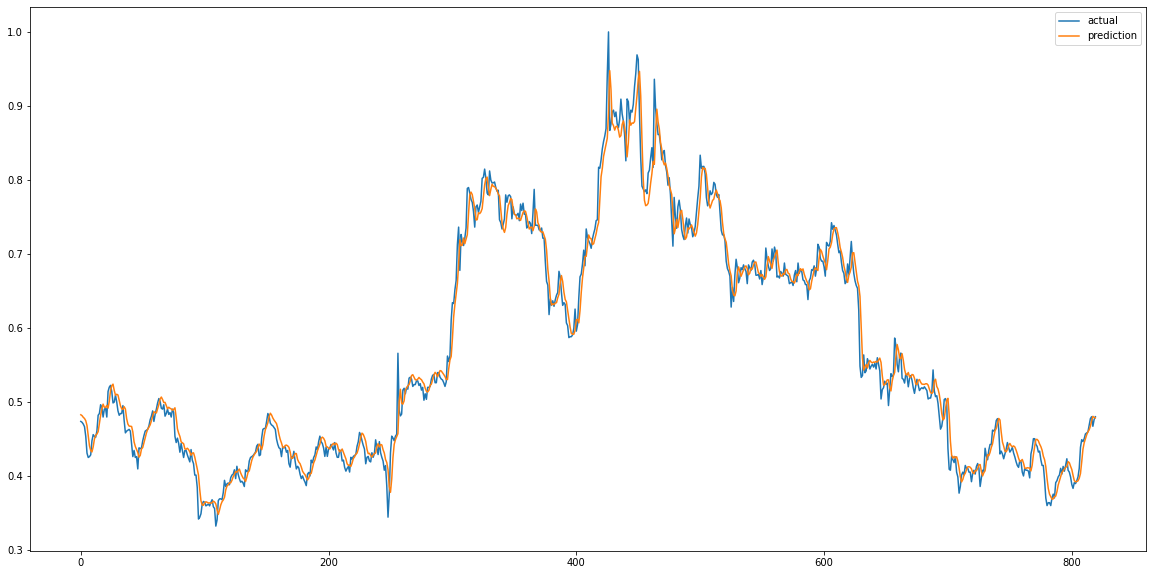

In [69]:
plt.figure(figsize=(20, 10))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()